In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import gymnasium as gym
from gymnasium import spaces
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize
import torch as th
from sb3_contrib import RecurrentPPO

SAVE_DIR = f"/Users/newuser/Projects/robust_algo_trader/drl/models/model_{dt.datetime.now().strftime('%Y%m%d_%H')}"
os.makedirs(SAVE_DIR, exist_ok=True)

DATA_DIR = "/Users/newuser/Projects/robust_algo_trader/data/gen_alpaca_data"
MASTER_SEED = 42

class TradingProfitEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    def __init__(self, signals_data, lookback_window=180, max_steps_per_trade=100,
                 commission_rate=0.003):
        super(TradingProfitEnv, self).__init__()

        self.signals_data = signals_data
        self.symbols = list(signals_data.keys())
        self.current_symbol = None
        self.lookback_window = lookback_window
        self.max_steps_per_trade = max_steps_per_trade
        self.commission_rate = commission_rate
        
        self.features = [
            'distance_from_mean',
            # 'distance_from_upper',
            # 'distance_from_lower',
            'rsi',
            'range_strength',
            'mean_reversion_probability',
            # 'is_range_market'
        ]
        
        self.action_map = {
            'HOLD': 0,
            'CLOSE': 1
        }
        self.reverse_action_map = {v: k for k, v in self.action_map.items()}
        self.action_space = spaces.Discrete(len(self.action_map))
        
        self.observation_space = spaces.Box(
            low=-1, 
            high=1, 
            shape=(lookback_window, len(self.features) + 1),
            dtype=np.float32
        )

        self.position = None
        self.position_type = None
        self.position_entry_step = None
        self.entry_price = None
        self.steps_in_trade = 0
        self.current_step = None
        self.trade_history = []
        
    def _find_next_entry_signal(self):
        signals = self.signals_data[self.current_symbol]
       
        if self.current_step is None:
            start_idx = self.lookback_window
        else:
            # Otherwise, start from the step after current position
            start_idx = self.current_step + 1
        
        # Look for the next entry signal in sequential order
        for i in range(start_idx, len(signals) - 1):
            action = signals.iloc[i]['action']
            if action in ['BUY', 'SELL']:
                self.current_step = i
                self.position_type = action
                self.position = 'LONG' if action == 'BUY' else 'SHORT'
                self.position_entry_step = i
                self.entry_price = signals.iloc[i]['price']
                return
        
        # If no more signals are found, set a flag to indicate end of data
        self.end_of_data = True
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Only change symbol when explicitly told to or at the beginning
        if self.current_symbol is None:
            self.current_symbol = random.choice(self.symbols)
        
        self.position = None
        self.position_type = None
        self.position_entry_step = None
        self.entry_price = None
        self.steps_in_trade = 0
        self.end_of_data = False
        
        # Find next entry signal (sequential)
        self._find_next_entry_signal()
        
        # If we've reached the end of data, wrap around to the beginning
        if hasattr(self, 'end_of_data') and self.end_of_data:
            self.current_step = self.lookback_window
            self.end_of_data = False
            self._find_next_entry_signal()
        
        return self._get_observation(), {}

    def _get_observation(self):
        signals = self.signals_data[self.current_symbol]

        start_idx = self.current_step - self.lookback_window
        end_idx = self.current_step
        window_data = signals.iloc[start_idx:end_idx]

        observations = np.zeros((self.lookback_window, len(self.features) + 1), dtype=np.float32)

        for i, feature in enumerate(self.features):
            window_values = window_data[feature].astype(float).values
            
            if feature == 'rsi':
                scaled_values = 2 * (window_values / 100) - 1
            elif feature == 'mean_reversion_probability':
                scaled_values = 2 * window_values - 1
            elif feature == 'is_range_market':
                scaled_values = 2 * window_values - 1
            elif feature in ['distance_from_mean']:
                scaled_values = window_values / 10
            elif feature in ['distance_from_upper', 'distance_from_lower']:
                scaled_values = 2 * (window_values / 100) - 1
            elif feature == 'range_strength':
                scaled_values = 2 * window_values - 1
            
            scaled_values = np.clip(scaled_values, -1, 1)
            observations[:, i] = scaled_values

        observations[:, -1] = self._get_position_state()
        return observations.astype(np.float32)

    def _get_position_state(self):
        if self.position is None:
            return 0.0
        elif self.position == 'LONG':
            return 1.0
        else:
            return -1.0
    
    def _calculate_unrealized_pnl(self, current_price):
        if self.position is None or self.entry_price is None:
            return 0.0
        pnl = 0.0
        if self.position == 'LONG':
            pnl = (current_price - self.entry_price) / self.entry_price
        elif self.position == 'SHORT':
            pnl = (self.entry_price - current_price) / self.entry_price
            
        return pnl
    
    def _calculate_reward(self, action, current_price):
        action_str = self.reverse_action_map[action]
        
        if action_str == 'CLOSE':
            if self.position == 'LONG':
                pnl = np.log(current_price / self.entry_price)
                pnl = (current_price - self.entry_price) / self.entry_price
            elif self.position == 'SHORT':
                pnl = np.log(self.entry_price / current_price)
                pnl = (self.entry_price - current_price) / self.entry_price
            else:
                return 0.0
                
            total_costs = np.log(self.entry_price * self.commission_rate)
            
            total_costs = self.commission_rate
            net_pnl = pnl - total_costs
            reward = net_pnl * 100
            # Bonus for profitable trades
            # if net_pnl > 0:
            #     reward += 1.0
                
            self.trade_history.append({
                'symbol': self.current_symbol,
                'position': self.position,
                'entry_step': self.position_entry_step,
                'exit_step': self.current_step,
                'entry_price': self.entry_price,
                'exit_price': current_price,
                'pnl': pnl,
                'net_pnl': net_pnl,
                'costs': total_costs,
                'duration': self.current_step - self.position_entry_step
            })
            
            return reward
        else:  # HOLD action
            return 0
            hold_reward = 0
            unrealized_pnl = self._calculate_unrealized_pnl(current_price)
            if unrealized_pnl > 0:
                hold_reward += unrealized_pnl * 5  # Significant scaling
            return hold_reward

    def step(self, action):
        signals = self.signals_data[self.current_symbol]
        current_price = signals.iloc[self.current_step]['price']
        done = (self.steps_in_trade >= self.max_steps_per_trade) or (self.current_step >= len(signals) - 1)
        if done:
            action = self.action_map['CLOSE']
        
        
        reward = self._calculate_reward(action, current_price)
        action_str = self.reverse_action_map[action]
        
        if action_str == 'CLOSE':
            self.position = None
            self.position_type = None
            self.position_entry_step = None
            self.entry_price = None
            done = True
        else:
            self.current_step += 1
            self.steps_in_trade += 1
        obs = self._get_observation()
        
        info = {
            "Reward": reward,
            "Position": self.position,
            "Position Type": self.position_type,
            "Action": action_str,
            "Current Price": current_price,
            "Entry Price": self.entry_price,
            "Current Symbol": self.current_symbol,
            "Steps in Trade": self.steps_in_trade,
            "Unrealized PnL": self._calculate_unrealized_pnl(current_price)
        }
        
        return obs, reward, done, False, info

    def render(self, mode='human'):
        pass

    def close(self):
        pass


TRADE COMPLETE - Recording trade data
Trade #1 completed - PnL: -3.88, New cash: 996.12
POSITION CLOSED BUT NOT RECORDED - Check logic
TRADE COMPLETE - Recording trade data
Trade #2 completed - PnL: 14.70, New cash: 1010.82
TRADE COMPLETE - Recording trade data
Trade #3 completed - PnL: 2.08, New cash: 1012.89
POSITION CLOSED BUT NOT RECORDED - Check logic
TRADE COMPLETE - Recording trade data
Trade #4 completed - PnL: -8.13, New cash: 1004.77
POSITION CLOSED BUT NOT RECORDED - Check logic
TRADE COMPLETE - Recording trade data
Trade #5 completed - PnL: -18.06, New cash: 986.71
TRADE COMPLETE - Recording trade data
Trade #6 completed - PnL: -1.71, New cash: 985.00
POSITION CLOSED BUT NOT RECORDED - Check logic
TRADE COMPLETE - Recording trade data
Trade #7 completed - PnL: 4.56, New cash: 989.56
POSITION CLOSED BUT NOT RECORDED - Check logic
POSITION CLOSED BUT NOT RECORDED - Check logic
TRADE COMPLETE - Recording trade data
Trade #8 completed - PnL: -2.38, New cash: 987.18
POSITION CLO

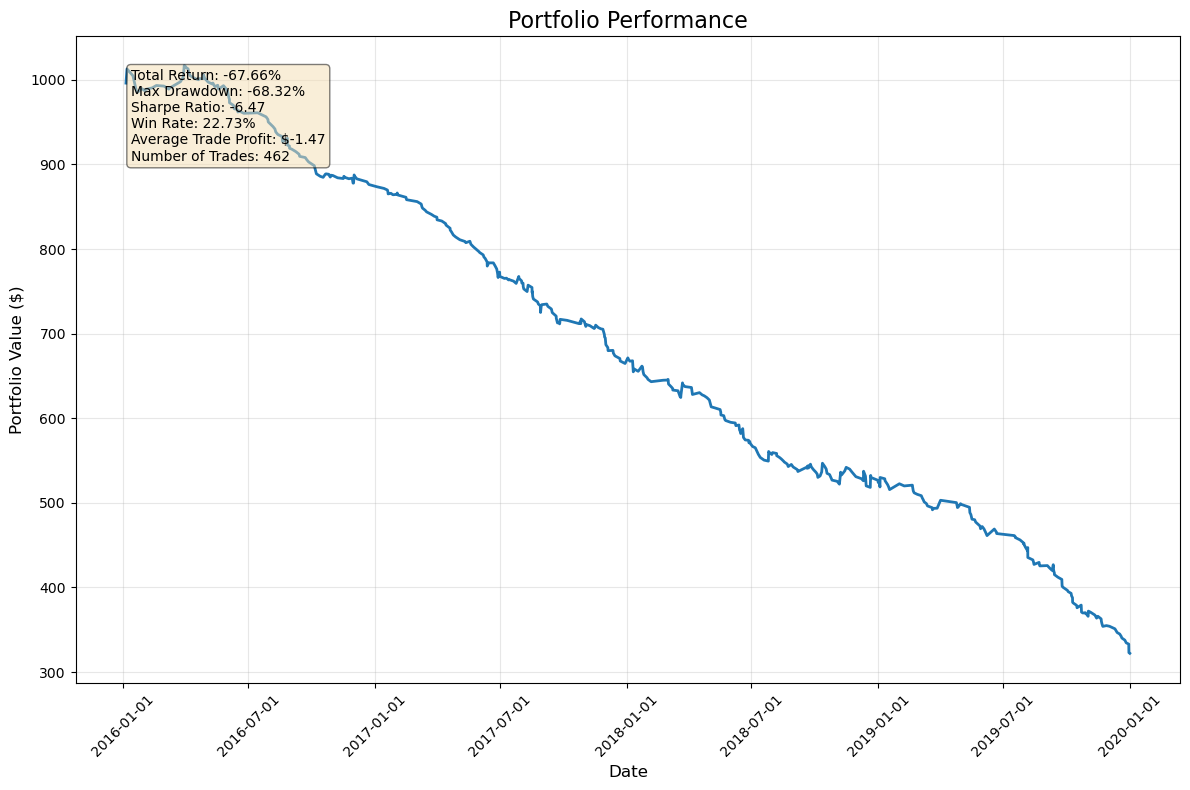

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from stable_baselines3.common.evaluation import evaluate_policy
import datetime as dt

def backtest_model(model, signals_data, initial_capital=10000, symbols=None):
    if symbols is None:
        symbols = list(signals_data.keys())
        
    env = TradingProfitEnv(signals_data)
    
    # Portfolio tracking
    portfolio = {
        'timestamp': [],
        'portfolio_value': [],
        'cash': [],
        'position_value': [],
        'returns': [],
        'trade_id': [],
        'symbol': [],
        'action': [],
        'price': [],
        'pnl': []
    }
    
    # Initialize portfolio
    cash = initial_capital
    position_value = 0
    trade_count = 0
    
    for symbol in symbols:
        env.current_symbol = symbol
        trading_complete = False
        
        # Track processed entry positions to avoid infinite loops
        processed_entries = set()
        
        while not trading_complete:
            obs, _ = env.reset()
            
            # Check if we've run out of entry signals
            if hasattr(env, 'end_of_data') and env.end_of_data:
                trading_complete = True
                continue
            
            # Check if we've already processed this entry position
            if env.position_entry_step in processed_entries:
                trading_complete = True
                continue
                
            # Add current entry to processed set
            processed_entries.add(env.position_entry_step)
            
            done = False
            lstm_state = None
            
            while not done:
                # Get action from model
                action, lstm_state = model.predict(obs, 
                                                state = lstm_state,
                                                deterministic=True)
                
                action_scalar = action.item() if isinstance(action, np.ndarray) else int(action)
                
                # Store position state before step
                had_position = env.position is not None
                
                # Step environment
                obs, reward, terminated, truncated, info = env.step(action_scalar)
                done = terminated or truncated
                
                # Get current timestamp
                current_time = signals_data[symbol].iloc[env.current_step]['timestamp']
                
                # Track portfolio value
                if action_scalar == env.action_map['CLOSE'] and env.position is None:
                    print("TRADE COMPLETE - Recording trade data")
                    # Trade completed
                    trade_count += 1
                    pnl_amount = reward * initial_capital / 100  # Convert percentage to amount
                    cash += pnl_amount
                    
                    print(f"Trade #{trade_count} completed - PnL: {pnl_amount:.2f}, New cash: {cash:.2f}")
                    
                    # Record portfolio state after trade
                    portfolio['timestamp'].append(current_time)
                    portfolio['portfolio_value'].append(cash + position_value)
                    portfolio['cash'].append(cash)
                    portfolio['position_value'].append(position_value)
                    portfolio['returns'].append(pnl_amount/initial_capital)
                    portfolio['trade_id'].append(trade_count)
                    portfolio['symbol'].append(symbol)
                    portfolio['action'].append(info['Action'])
                    portfolio['price'].append(info['Current Price'])
                    portfolio['pnl'].append(pnl_amount)
                elif had_position and env.position is None:
                    print("POSITION CLOSED BUT NOT RECORDED - Check logic")
                
                # If done but no CLOSE action (e.g., end of data), force close position
                if done and env.position is not None:
                    print("FORCE CLOSING position at end of data")
                    trade_count += 1
                    # Use the info dictionary's Unrealized PnL value instead of calling private method
                    pnl_amount = info['Unrealized PnL'] * initial_capital
                    cash += pnl_amount
                    position_value = 0
                    
                    print(f"Force closed trade #{trade_count} - PnL: {pnl_amount:.2f}, New cash: {cash:.2f}")
                    
                    # Record final state
                    portfolio['timestamp'].append(current_time)
                    portfolio['portfolio_value'].append(cash + position_value)
                    portfolio['cash'].append(cash)
                    portfolio['position_value'].append(position_value)
                    portfolio['returns'].append(pnl_amount/initial_capital)
                    portfolio['trade_id'].append(trade_count)
                    portfolio['symbol'].append(symbol)
                    portfolio['action'].append('FORCE_CLOSE')
                    portfolio['price'].append(info['Current Price'])
                    portfolio['pnl'].append(pnl_amount)
    
    print(f"Total trades recorded: {len(portfolio['trade_id'])}")
    
    # Convert to DataFrame
    portfolio_df = pd.DataFrame(portfolio)
    
    # Convert timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(portfolio_df['timestamp']):
        portfolio_df['timestamp'] = pd.to_datetime(portfolio_df['timestamp'])
    
    # Sort by timestamp
    portfolio_df = portfolio_df.sort_values('timestamp')
    
    # Calculate cumulative returns
    portfolio_df['cumulative_return'] = (1 + portfolio_df['returns']).cumprod() - 1
    
    return portfolio_df


def calculate_performance_metrics(portfolio_df):
    # Initial and final portfolio values
    initial_value = portfolio_df['portfolio_value'].iloc[0]
    final_value = portfolio_df['portfolio_value'].iloc[-1]
    
    # Total return
    total_return = (final_value / initial_value) - 1
    
    # Calculate drawdowns
    portfolio_df['previous_peak'] = portfolio_df['portfolio_value'].cummax()
    portfolio_df['drawdown'] = (portfolio_df['portfolio_value'] - portfolio_df['previous_peak']) / portfolio_df['previous_peak']
    max_drawdown = portfolio_df['drawdown'].min()
    
    # Win rate
    win_rate = len(portfolio_df[portfolio_df['pnl'] > 0]) / len(portfolio_df)
    
    # Average profit per trade
    avg_profit = portfolio_df['pnl'].mean()
    
    # Sharpe ratio (assuming daily data, annualized)
    returns_series = portfolio_df['returns']
    sharpe_ratio = (returns_series.mean() / returns_series.std()) * np.sqrt(252)  # Annualized
    
    metrics = {
        'Total Return': f"{total_return:.2%}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Win Rate': f"{win_rate:.2%}",
        'Average Trade Profit': f"${avg_profit:.2f}",
        'Number of Trades': len(portfolio_df)
    }
    
    return metrics


def plot_portfolio_curve(portfolio_df, metrics=None, save_path=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot portfolio value
    ax.plot(portfolio_df['timestamp'], portfolio_df['portfolio_value'], linewidth=2)
    
    # Format x-axis as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    
    # Add title and labels
    ax.set_title('Portfolio Performance', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add metrics as text box if provided
    if metrics:
        metrics_text = '\n'.join(f"{k}: {v}" for k, v in metrics.items())
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    return fig, ax


# Example usage
if __name__ == "__main__":
    # Load the trained model
    model = RecurrentPPO.load("/Users/newuser/Projects/robust_algo_trader/drl/models/model_20250410_18/final_profit_model")
    
    # Load test data (preferably out-of-sample)
    signals_data = pd.read_csv(os.path.join(DATA_DIR, 'QQQ_M1_signals.csv'))
    # signals_data = signals_data.iloc[:50000]
    
    test_data = {
        'CRM': signals_data
        # Add more symbols as needed
    }
    
    # Run backtest
    portfolio_results = backtest_model(model, test_data, initial_capital=1_000)
    
    # Calculate performance metrics
    metrics = calculate_performance_metrics(portfolio_results)
    print("\nPerformance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v}")
    
    # Plot portfolio curve
    plot_portfolio_curve(portfolio_results, metrics)
    plt.show()

In [ ]:
signals_data